<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import ee
import geemap
import datetime
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ee.Authenticate()
ee.Initialize(project='ee-f44081050')
map = geemap.Map()
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [13]:
#To draw User defined AOI
shp = map.user_roi
#shp = ee.FeatureCollection('projects/ee-p66121061/assets/drive-download-20240802T030740Z-001')

In [14]:
# Apply Cloud Masking & Scale factor

def maskL5(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Cirrus
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

# Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B6').multiply(0.00341802).add(149.0)

# Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

def maskL8(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Cirrus
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

# Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

# Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

In [15]:
# Create a list Landsat 5, 4 monthly
coll1 = []

# Initial date
Date1 = datetime.date(1990, 1, 1)
# Final date
Date = datetime.date(2012, 12, 31)

# Months interval (To compute n monthly composite image, set K = n-1)
k = 3
while Date1 <= Date:
    outyr = Date1.year + (Date1.month - 1 + k) // 12
    outmonth = (Date1.month - 1 + k) % 12 + 1

    # Adjust the month and year
    if Date1.month + k > 12:
        outyr = Date1.year + 1
        outmonth = (Date1.month + k) % 12

    # Adjust the day to the last day of the month
    outday = calendar.monthrange(outyr, outmonth)[1]

    Date2 = datetime.date(outyr, outmonth, outday)

    iniDate = str(Date1)
    endDate = str(Date2)

    dataset = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filterBounds(shp) \
        .filterDate(iniDate, endDate) \
        .map(maskL5)

    # select one image from collection to copy its properties to the composite image
    img1 = dataset.first()

    # Get Composite image date & season
    x = str(Date1.year)
    y = int(Date1.month)

    # Change according to months used to generate composite image
    Jan_apr = [1, 2, 3, 4]
    May_aug = [5, 6, 7, 8]
    sep_dec = [9, 10, 11, 12]

    if y in Jan_apr:
        s = str("Jan_apr")
    elif y in May_aug:
        s = str("May_aug")
    elif y in sep_dec:
        s = str("sep_dec")

    season = s + x

    size = dataset.size().getInfo()
    if size >= 1:
        composite = dataset.median().copyProperties(img1, ['system:time_start'])
        coll1.append(composite)

        print(season + "-" + str(size) + "__" + iniDate + "_" + endDate)
    else:
        print("No image in " + season)

    # Update Date1 for the next iteration
    Date1 = Date2 + datetime.timedelta(days=1)

collection_L5 = ee.ImageCollection.fromImages(coll1)

Jan_apr1990-6__1990-01-01_1990-04-30
May_aug1990-5__1990-05-01_1990-08-31
sep_dec1990-5__1990-09-01_1990-12-31
Jan_apr1991-6__1991-01-01_1991-04-30
May_aug1991-7__1991-05-01_1991-08-31
sep_dec1991-7__1991-09-01_1991-12-31
Jan_apr1992-5__1992-01-01_1992-04-30
May_aug1992-6__1992-05-01_1992-08-31
sep_dec1992-5__1992-09-01_1992-12-31
Jan_apr1993-6__1993-01-01_1993-04-30
May_aug1993-7__1993-05-01_1993-08-31
sep_dec1993-5__1993-09-01_1993-12-31
Jan_apr1994-6__1994-01-01_1994-04-30
May_aug1994-5__1994-05-01_1994-08-31
sep_dec1994-7__1994-09-01_1994-12-31
Jan_apr1995-5__1995-01-01_1995-04-30
May_aug1995-3__1995-05-01_1995-08-31
sep_dec1995-4__1995-09-01_1995-12-31
Jan_apr1996-6__1996-01-01_1996-04-30
May_aug1996-7__1996-05-01_1996-08-31
sep_dec1996-7__1996-09-01_1996-12-31
Jan_apr1997-5__1997-01-01_1997-04-30
May_aug1997-6__1997-05-01_1997-08-31
sep_dec1997-5__1997-09-01_1997-12-31
Jan_apr1998-5__1998-01-01_1998-04-30
May_aug1998-3__1998-05-01_1998-08-31
sep_dec1998-6__1998-09-01_1998-12-31
J

In [17]:
#Create another List for Landsat 8, 4 monthly
coll2 = []

#Initial date
Date1 = datetime.date(2013,1,1)
#Final date
Date = datetime.date(2023,12,31)

#months interval(To compute n monthly composite image, set K = n-1)
k=3

while Date1 <= Date:
    outyr = Date1.year + (Date1.month-1+k)//12
    outmonth = (Date1.month-1+k)%12 +1

    # Adjust the month and year
    if Date1.month + k > 12:
        outyr = Date1.year + 1
        outmonth = (Date1.month + k) % 12

    # Adjust the day to the last day of the month
    outday = calendar.monthrange(outyr, outmonth)[1]

    Date2 = datetime.date(outyr,outmonth,outday)

    iniDate = str(Date1)
    endDate = str(Date2)

    dataset_L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
        .filterBounds(shp) \
        .filterDate(iniDate,endDate) \
        .map(maskL8)

    #select one image from collection to copy its properties to the composite image
    img1 = dataset_L8.first()

    #Get Composite image date & season
    x = str(Date1.year)
    y = int(Date1.month)

    Jan_apr = [1,2,3,4]
    May_aug = [5,6,7,8]
    sep_dec = [9,10,11,12]

    if y in Jan_apr:
        s = str("Jan_apr")
    elif y in May_aug:
        s = str("May_aug")
    elif y in sep_dec:
        s = str("sep_dec")

    season = s+x

    size = dataset_L8.size().getInfo()
    if size>=1:
        composite = dataset_L8.median().copyProperties(img1, ['system:time_start'])
        coll2.append(composite)

        print(season+"-"+str(size)+"__"+iniDate+"_"+endDate)
    else:
        print("No image in "+season)

    # Update Date1 for the next iteration
    Date1 = Date2 + datetime.timedelta(days=1)

collection_L8 = ee.ImageCollection.fromImages(coll2)

Jan_apr2013-1__2013-01-01_2013-04-30
May_aug2013-5__2013-05-01_2013-08-31
sep_dec2013-5__2013-09-01_2013-12-31
Jan_apr2014-8__2014-01-01_2014-04-30
May_aug2014-7__2014-05-01_2014-08-31
sep_dec2014-8__2014-09-01_2014-12-31
Jan_apr2015-7__2015-01-01_2015-04-30
May_aug2015-6__2015-05-01_2015-08-31
sep_dec2015-7__2015-09-01_2015-12-31
Jan_apr2016-6__2016-01-01_2016-04-30
May_aug2016-7__2016-05-01_2016-08-31
sep_dec2016-7__2016-09-01_2016-12-31
Jan_apr2017-7__2017-01-01_2017-04-30
May_aug2017-7__2017-05-01_2017-08-31
sep_dec2017-7__2017-09-01_2017-12-31
Jan_apr2018-6__2018-01-01_2018-04-30
May_aug2018-6__2018-05-01_2018-08-31
sep_dec2018-7__2018-09-01_2018-12-31
Jan_apr2019-5__2019-01-01_2019-04-30
May_aug2019-7__2019-05-01_2019-08-31
sep_dec2019-5__2019-09-01_2019-12-31
Jan_apr2020-8__2020-01-01_2020-04-30
May_aug2020-6__2020-05-01_2020-08-31
sep_dec2020-7__2020-09-01_2020-12-31
Jan_apr2021-6__2021-01-01_2021-04-30
May_aug2021-6__2021-05-01_2021-08-31
sep_dec2021-7__2021-09-01_2021-12-31
J

In [18]:
#Compute MNDWI Images for both collection and merge them
#MNDWI = (Green - SWIR1) / (Green + SWIR1)
#NDVI = (NIR - Red) / (NIR + Red)
#NDBI = (SWIR1 - NIR) / (SWIR1 + NIR)
#PISI = 0.8192∗Blue − 0.5735∗NIR+0.075

def mndwi_fn_L5(image):
    mndwi = image.normalizedDifference(['SR_B2','SR_B5']).rename('mndwi')
    #mndwi = image.expression(
        #'0.8192 * blue - 0.5735 * nir + 0.075', {
            #'blue': image.select('SR_B1'),
            #'nir': image.select('SR_B4')
        #}).rename('mndwi')
    return image.addBands(mndwi)

def mndwi_fn_L8(image):
    mndwi = image.normalizedDifference(['SR_B3','SR_B6']).rename('mndwi')
    #mndwi = image.expression(
        #'0.8192 * blue - 0.5735 * nir + 0.075', {
            #'blue': image.select('SR_B2'),
            #'nir': image.select('SR_B5')
        #}).rename('mndwi')
    return image.addBands(mndwi)

mndwi_L5 = collection_L5.map(mndwi_fn_L5)
mndwi_L8 = collection_L8.map(mndwi_fn_L8)
mndwi_coll = mndwi_L5.merge(mndwi_L8)

In [19]:
#Compute NDBI Images for both collection and merge them
#MNDWI = (Green - SWIR1) / (Green + SWIR1)
#NDVI = (NIR - Red) / (NIR + Red)
#NDBI = (SWIR1 - NIR) / (SWIR1 + NIR)
#PISI = 0.8192∗Blue − 0.5735∗NIR+0.075

def ndbi_fn_L5(image):
    ndbi = image.normalizedDifference(['SR_B5','SR_B4']).rename('ndbi')
    return image.addBands(ndbi)

def ndbi_fn_L8(image):
    ndbi = image.normalizedDifference(['SR_B6','SR_B5']).rename('ndbi')
    return image.addBands(ndbi)

ndbi_L5 = collection_L5.map(ndbi_fn_L5)
ndbi_L8 = collection_L8.map(ndbi_fn_L8)
ndbi_coll = ndbi_L5.merge(ndbi_L8)

In [20]:
#Add a time band to the MNDWI collection
def Timeband(image):
    return image.addBands(image.metadata('system:time_start').divide(1000*60*60*24*365))

def clip_aoi_mndwi(image):
    return image.addBands(image.clip(shp).rename('mndwi_aoi'))

mndwi_collection = mndwi_coll.select('mndwi').map(clip_aoi_mndwi).map(Timeband)

In [21]:
#Add a time band to the NDBI collection
def Timeband(image):
    return image.addBands(image.metadata('system:time_start').divide(1000*60*60*24*365))

def clip_aoi_ndbi(image):
    return image.addBands(image.clip(shp).rename('ndbi_aoi'))

ndbi_collection = ndbi_coll.select('ndbi').map(clip_aoi_ndbi).map(Timeband)

In [22]:
# Compute Trend for the whole time series
trend_mndwi = mndwi_collection.select(['system:time_start','mndwi_aoi']).reduce(ee.Reducer.linearFit())
trend_ndbi = ndbi_collection.select(['system:time_start','ndbi_aoi']).reduce(ee.Reducer.linearFit())

#MNDWI
# 提取斜率
slope_mndwi = trend_mndwi.select('scale')

# 計算斜率的最小值和最大值
min_slope_mndwi = ee.Number(slope_mndwi.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=shp,
    scale=30,
    maxPixels=1e13
).get('scale'))

max_slope_mndwi = ee.Number(slope_mndwi.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=shp,
    scale=30,
    maxPixels=1e13
).get('scale'))

# 正規化斜率到-1到1之間
normalized_slope_mndwi = slope_mndwi.subtract(min_slope_mndwi).divide(max_slope_mndwi.subtract(min_slope_mndwi)).multiply(2).subtract(1).multiply(900)


# 合成正規化後的趨勢影像
normalized_trend_mndwi = trend_mndwi.addBands(normalized_slope_mndwi.rename('normalized_scale'), overwrite=True)

# 可視化正規化後的趨勢圖
map.addLayer(normalized_trend_mndwi, {'min': -900, 'max': 900, 'bands': ['normalized_scale'], 'palette': ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6']}, 'Normalized Trend_MNDWI')


In [23]:
#NDBI
# 提取斜率
slope_ndbi = trend_ndbi.select('scale')

# 計算斜率的最小值和最大值
min_slope_ndbi = ee.Number(slope_ndbi.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=shp,
    scale=30,
    maxPixels=1e13
).get('scale'))

max_slope_ndbi = ee.Number(slope_ndbi.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=shp,
    scale=30,
    maxPixels=1e13
).get('scale'))

# 正規化斜率到-1到1之間
normalized_slope_ndbi = slope_ndbi.subtract(min_slope_ndbi).divide(max_slope_ndbi.subtract(min_slope_ndbi)).multiply(2).subtract(1).multiply(900)


# 合成正規化後的趨勢影像
normalized_trend_ndbi = trend_ndbi.addBands(normalized_slope_ndbi.rename('normalized_scale'), overwrite=True)

# 可視化正規化後的趨勢圖
map.addLayer(normalized_trend_ndbi, {'min': -900, 'max': 900, 'bands': ['normalized_scale'], 'palette': ['#66A000','#99B718','#ffffbf','#fdae61','#d7191c']}, 'Normalized Trend_NDBI')

In [24]:
#正規化
# 合併 MNDWI, NDVI, NDBI 趨勢影像
combined_trend = normalized_trend_mndwi.select('normalized_scale').addBands(
    normalized_trend_ndbi.select('normalized_scale')
)
combined_trend = combined_trend.rename(['MNDWI_trend', 'NDBI_trend'])

# 計算每個波段的像元數量
pixel_count = combined_trend.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=shp,
    scale=30,
    maxPixels=1e13
)

# 打印每個波段的像元數量
print('Pixel count for MNDWI:', pixel_count.get('MNDWI_trend').getInfo())
print('Pixel count for NDBI:', pixel_count.get('NDBI_trend').getInfo())


Pixel count for MNDWI: 570714
Pixel count for NDBI: 570714


In [25]:
pip show geemap

Name: geemap
Version: 0.34.5
Summary: A Python package for interactive mapping using Google Earth Engine and ipyleaflet
Home-page: https://github.com/gee-community/geemap
Author: 
Author-email: Qiusheng Wu <giswqs@gmail.com>
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: bqplot, colour, earthengine-api, eerepr, folium, geocoder, ipyevents, ipyfilechooser, ipyleaflet, ipytree, matplotlib, numpy, pandas, plotly, pyperclip, pyshp, python-box, scooby, setuptools
Required-by: 


In [26]:
import geemap
help(geemap.Map.add_legend)

Help on function add_legend in module geemap.geemap:

add_legend(self, title: str = 'Legend', legend_dict: Optional[Dict[str, str]] = None, keys: Optional[List[str]] = None, colors: Optional[List[str]] = None, position: str = 'bottomright', builtin_legend: Optional[str] = None, layer_name: Optional[str] = None, add_header: bool = True, widget_args: Dict[str, Any] = {}, **kwargs: Any) -> None
    Adds a customized basemap to the map.
    
    Args:
        title (str, optional): Title of the legend. Defaults to 'Legend'.
        legend_dict (dict, optional): A dictionary containing legend items
            as keys and color as values. If provided, keys and
            colors will be ignored. Defaults to None.
        keys (list, optional): A list of legend keys. Defaults to None.
        colors (list, optional): A list of legend colors. Defaults to None.
        position (str, optional): Position of the legend. Defaults to
            'bottomright'.
        builtin_legend (str, optional

In [27]:
pip install --upgrade geemap

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [28]:
import IPython.display as display
import ee

# 生成圖片 URL
url = combined_trend.getThumbURL({
    'min': -900,
    'max': 900,
    'bands': ['MNDWI_trend'],
    'palette': ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6'],
    'region': shp,  # 使用 shp 幾何形狀
    'dimensions': 800,  # 調整縮略圖的尺寸
})

# 顯示圖片
display.Image(url=url)   # 顯示第一張圖片


In [29]:
url2 = combined_trend.getThumbURL({
    'min': -900,
    'max': 900,
    'bands': ['NDBI_trend'],
    'palette': ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6'],
    'region': shp,  # 使用 shp 幾何形狀
    'dimensions': 800,  # 調整縮略圖的尺寸
})

display.Image(url=url2)

In [30]:
!pip install matplotlib-scalebar


Saving 64c9efa260f021dca8379c4293f581f0-b9bcd16ab97ad62a9fb5db5599fe7a92_getPixels.png to 64c9efa260f021dca8379c4293f581f0-b9bcd16ab97ad62a9fb5db5599fe7a92_getPixels.png


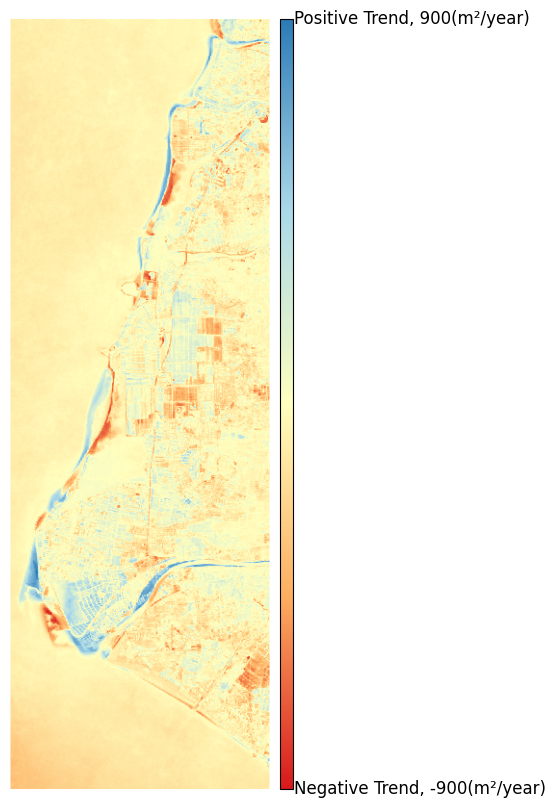

In [31]:
#!pip install matplotlib-scalebar

from google.colab import files
import io
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 上傳 PNG 檔案到 Colab
uploaded = files.upload()

# 讀取上傳的檔案
file_name = list(uploaded.keys())[0]
image = Image.open(io.BytesIO(uploaded[file_name]))

# 生成顯示圖片的 subplot
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(image)

# 設置 color bar 的位置和尺寸
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# 定義色碼映射
cmap = LinearSegmentedColormap.from_list(
    #MNDWI
    'custom', ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'], N=256
    #NDVI
    #'custom', ['#d7191c' ,'#fdae61', '#ffffbf', '#99B718', '#66A000'], N=256
    #NDBI
    #'custom', ['#66A000' ,'#99B718', '#ffffbf', '#fdae61', '#d7191c'], N=256
)


# 設置 color bar 的顏色映射，去除數值標籤
cbar = ColorbarBase(cax, cmap=cmap, orientation='vertical', ticks=[])

# 在 color bar 的藍色右邊標示 Positive Trend（黑色字體）
cbar.ax.text(1.05, 1.0, 'Positive Trend, 900(m²/year)', color='black', fontsize=12, ha='left', va='center', rotation=0)

# 在 color bar 的紅色右邊標示 Negative Trend（黑色字體）
cbar.ax.text(1.05, 0.0, 'Negative Trend, -900(m²/year)', color='black', fontsize=12, ha='left', va='center', rotation=0)


# 隱藏 xy 軸
ax.set_axis_off()

# 顯示圖片
plt.show()

Saving 584a3790ee90d25e057bfcafe6951093-d5d460999fe35a14ea1808839dbd2fe1_getPixels.png to 584a3790ee90d25e057bfcafe6951093-d5d460999fe35a14ea1808839dbd2fe1_getPixels.png


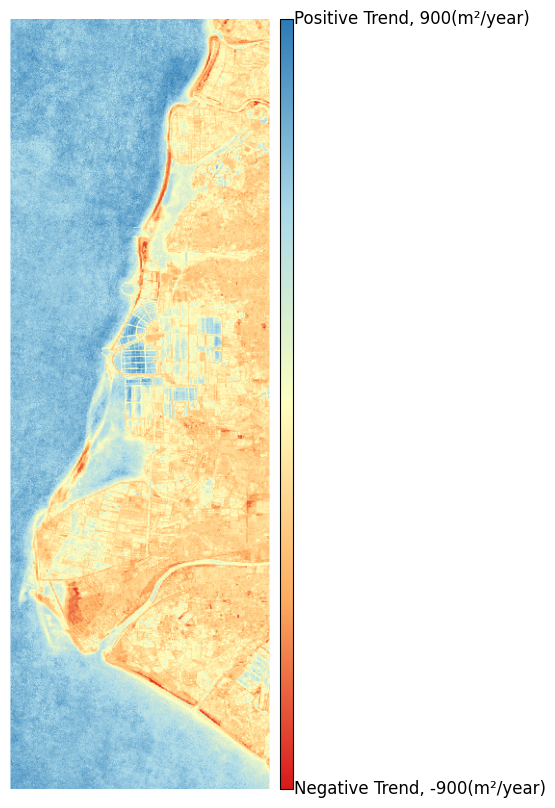

In [32]:
# 上傳 PNG 檔案到 Colab
uploaded = files.upload()

# 讀取上傳的檔案
file_name = list(uploaded.keys())[0]
image = Image.open(io.BytesIO(uploaded[file_name]))

# 生成顯示圖片的 subplot
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(image)

# 設置 color bar 的位置和尺寸
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# 定義色碼映射
cmap = LinearSegmentedColormap.from_list(
    #MNDWI
    'custom', ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'], N=256
    #NDVI
    #'custom', ['#d7191c' ,'#fdae61', '#ffffbf', '#99B718', '#66A000'], N=256
    #NDBI
    #'custom', ['#66A000' ,'#99B718', '#ffffbf', '#fdae61', '#d7191c'], N=256
)


# 設置 color bar 的顏色映射，去除數值標籤
cbar = ColorbarBase(cax, cmap=cmap, orientation='vertical', ticks=[])

# 在 color bar 的藍色右邊標示 Positive Trend（黑色字體）
cbar.ax.text(1.05, 1.0, 'Positive Trend, 900(m²/year)', color='black', fontsize=12, ha='left', va='center', rotation=0)

# 在 color bar 的紅色右邊標示 Negative Trend（黑色字體）
cbar.ax.text(1.05, 0.0, 'Negative Trend, -900(m²/year)', color='black', fontsize=12, ha='left', va='center', rotation=0)


# 隱藏 xy 軸
ax.set_axis_off()

# 顯示圖片
plt.show()

In [38]:
#輸出geotiff檔

# shp = shp.geometry()

task = ee.batch.Export.image.toDrive(image=normalized_trend_mndwi,
                    description='mndwi_trend',
                    scale=30,
                    region=map.user_roi,
                    fileNamePrefix='mndwi_trend',
                    crs='EPSG:4326',
                    fileFormat='GeoTIFF')
task.start()

In [39]:
#輸出geotiff檔

# shp = shp.geometry()

task = ee.batch.Export.image.toDrive(image=normalized_trend_ndbi,
                    description='ndbi_trend',
                    scale=30,
                    region=map.user_roi,
                    fileNamePrefix='ndbi_trend',
                    crs='EPSG:4326',
                    fileFormat='GeoTIFF')
task.start()